# Exploratory Data Analysis

The **goal** of EDA is profiling (assessing data quality) and discovery (gaining new insight from the data).



| Column name | description |
|---:|:---|
| Listed property price(€)  | The rental price of the property(per month or per week). |
| Address  | The address of the property. |
| Bedroom(s) | The number of bedrooms. |
| Bathroom(s)  | The number of bathrooms. |
| Property desc  | The description of the property. |
| Week YN  | 1 inidctaes the listed property price is per week, 0 not. |
| Month YN  | 1 inidctaes the listed property price is per week, 0 not. |
| Furnished status  | 1 indicates a property is furnished, 0 not.|
| Longitude  | The longitude of the property |
| latitude | The latitude of the property |
| dist_bridge  | The distance from the property to 0'Connell bridge |
| dist_ifsc  | The distance from the property to the IFSC |
| dist_silicon_docks | The distance from the property to the area termed 'silicon docks' |
| coord | The coordinates of the property (latitude,longitude |
| price level  | The average price level of nearby restaurants to the  property(0 to 4) |
| rating  | The  average review rating  of nearby restaurants to the  property(0 to 4) |
|Post code | The dublin postal code of the property. | 
|Type | The type of property either house or apartment. |
| Monthly property price(€) | The rental price of the property per month. |

### Importing the needed libaries..

In [1]:
import pandas as pd
import gmaps 
import os
import matplotlib.pyplot as plot
import seaborn as sns
import numpy as np
import wordcloud
from wordcloud import WordCloud,STOPWORDS
from PIL import Image
import scipy.stats as stats

In [76]:
rent_df = pd.read_hdf("../data/collected_rented_data.h5")
rent_df = rent_df[rent_df.rating != "" ]
#google places mixed up sometimes between a dublin in america and ireland .
rent_df = rent_df[rent_df["dist_ifsc"] < 100]

In [77]:
rent_df = rent_df[rent_df["Bedroom(s)"] > 0]

In [78]:
rent_df.iloc[:,5:13] =rent_df.iloc[:,5:13].apply(pd.to_numeric)


I choose to fill in the missing values of rating and price level with  the median as the percentage of null values was low. (0.4 and 4 percent respectively). Median was chosen as to prevent the influence of outliers.

In [79]:
rating =pd.to_numeric(rent_df['rating'],errors='coerce')

In [80]:
price_level =pd.to_numeric(rent_df['price level'],errors='coerce')

In [81]:
rent_df['price level'].fillna(value = price_level.median(),inplace=True)
rent_df['rating'].fillna(value = rating.median(),inplace=True)

In [82]:
rent_df.iloc[:,-2:] =rent_df.iloc[:,-2:].apply(pd.to_numeric)


In the next few cells, I added extra features to my dataframe such as Monthly rent price(€)(The rental price of a property per month), type (The type of property either house or apartment) ,and postcode (The Dublin postal code of the property.)  I also decided to remove "Listed property price" as this was no longer needed and rearranged the columns to clarify my own understanding.

In [84]:
#adding monthly rent price 
        
rent_df["Monthly rent price(€)"] = rent_df.apply(lambda x: ((x['Listed property price(€)'] * 52) / 12) if x['Week YN'] == 1 else x['Listed property price(€)'],  axis = 1)
rent_df["Monthly rent price(€)"]  = rent_df["Monthly rent price(€)"].apply(lambda x: round(x,2 ))

In [85]:
pd.set_option('max_colwidth',80)
rent_df = rent_df.replace(r'\\n','', regex=True)
rent_df.reset_index(inplace=True,drop=True)
rent_df["Type"] = None

for i,value in rent_df["Property desc"].items():
        if "house" in value.lower() or "home" in value.lower() or "property" in value.lower():
            rent_df.iloc[i, -1] = "house"
        if "apartment" in value.lower() or "flat" in value.lower() or 'studio' in value.lower() or 'apt' in value.lower() or 'penthouse' in value.lower():
            rent_df.iloc[i, -1] = "apartment"
                  
rent_df.dropna(subset=["Type"],inplace=True)
            


In [86]:
rent_df.reset_index(inplace=True,drop=True)
rent_df["Post code"] = None
    
    
for index,value in rent_df["Address"].items():
    i = 0
    list_address = value.split(" ")
    number = None
    while i < len(list_address):
        if list_address[i].lower() == "dublin" and i != len(list_address) - 1:
            if list_address[i + 1].strip().isalnum():
                number = list_address[i + 1]
                number = number.replace(",", "").replace("Road","")
        i = i + 1

    rent_df.iloc[index,-1] = number

In [87]:
rent_df.dropna(subset=["Post code"],inplace=True)
rent_df.reset_index(inplace=True,drop=True)
#dropping listed price
rent_df.drop('Listed property price(€)', axis=1,inplace=True)

In [88]:
cols = rent_df.columns.tolist()
cols = [ 'Monthly rent price(€)',
        'Type',
    'Address',
        'Post code',
 'Bedroom(s)',
 'Bathroom(s)',
 'Property desc',
 'Week YN',
 'Month YN',
 'Furnished Status',
 'Longitude',
 'latitude',
 'dist_bridge',
 'dist_ifsc',
 'dist_silicon_docks',
 'coord',
 'price level',
 'rating']
rent_df = rent_df[cols]
rent_df.head()

,Monthly rent price(€),Type,Address,Post code,Bedroom(s),Bathroom(s),Property desc,Week YN,Month YN,Furnished Status,Longitude,latitude,dist_bridge,dist_ifsc,dist_silicon_docks,coord,price level,rating
0,1600.0,apartment,"Earlsfield Court, FRANCIS STREET, Dublin 8",8,2,1,Available 1st June - Two double bedroom apartment in very well maintained an...,0,1,1,-6.274056,53.339771,1.290848,2.188464,2.462037,"53.3397711,-6.2740561",2.500000,4.039655
1,1500.0,apartment,"Clearwater Court North Royal Canal Park, Royal Canal Park, Dublin 15",15,2,1,"Available Now - Super spacious, interior designed and presented to a high st...",0,1,1,-6.317532,53.377553,5.141023,5.725532,6.532332,"53.3775534,-6.3175322",1.750000,4.356818
2,2200.0,apartment,"Gallery Quay, Hanover Quay, Dublin 2",2,2,2,Available Now - Beautiful dual aspect top floor apartment flooded with light...,0,1,1,-6.239015,53.342941,1.430174,0.844296,0.111624,"53.3429414,-6.2390153",3.000000,4.019298
3,1650.0,apartment,"Apt.2 Shelbourne Village, Ringsend, Dublin 4., Ballsbridge, Dublin 4",4,1,1,Available Now - Modern apartment in the heart of the silicon docks. Around t...,0,1,1,-6.235334,53.341877,1.701127,1.081645,0.235971,"53.3418769,-6.2353345",3.000000,4.213462
4,2200.0,house,"Kimmage Grove, Kimmage, Dublin 6w",6w,3,1,Available 1st June - Beautiful 3 bed semi detached house close to all amenit...,0,1,1,-6.291463,53.316600,4.030473,4.771825,4.672201,"53.3165996,-6.2914635",1.666667,4.236842


In [25]:
rent_df.describe()

,Monthly rent price(€),Bedroom(s),Bathroom(s),Week YN,Month YN,Furnished Status,Longitude,latitude,dist_bridge,dist_ifsc,dist_silicon_docks,price level,rating
count,2037.000000,2037.00000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,1920.000000,2037.000000
mean,2125.632636,2.03731,1.539519,0.062838,0.937162,0.961217,-6.260323,53.337744,3.296497,3.492668,3.499426,2.193589,4.142047
std,844.130087,1.03266,0.795391,0.242730,0.242730,0.193124,0.042831,0.028313,2.884203,2.922756,2.917431,0.603940,0.167268
min,541.670000,0.00000,1.000000,0.000000,0.000000,0.000000,-6.446355,53.211262,0.046333,0.012100,0.083746,1.000000,3.738462
25%,1600.000000,1.00000,1.000000,0.000000,1.000000,1.000000,-6.272088,53.325677,1.398484,1.528210,1.724637,1.744318,4.006667
50%,2000.000000,2.00000,1.000000,0.000000,1.000000,1.000000,-6.258433,53.340413,2.157850,2.507124,2.526088,2.000000,4.130612
75%,2450.000000,2.00000,2.000000,0.000000,1.000000,1.000000,-6.237887,53.350725,4.071956,4.354209,4.357865,2.800000,4.259259
max,9100.000000,9.00000,9.000000,1.000000,1.000000,1.000000,-6.063090,53.422143,16.105668,16.051408,15.550015,3.285714,4.800000


# Analysing continuous  features:

### Understanding the distribution of each continuous feature:

We can see that the  monthly rental prices are skewed right with outliers lying above 4,000. 

Both longitude and latitude distributions are what we expect to see given that latitude of Dublin, Ireland is 53.350140, and the longitude is -6.266155.

dist_bridge,dist_ifsc, dist_silicon_docks are skewed right with outliers above 8 km.

The distributions of price_level and rating are more ambiguous showing multiple modes.





Histogram of Monthly rent price(€)


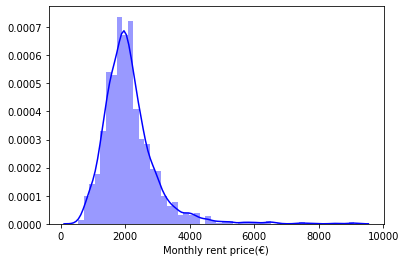

Histogram of Longitude


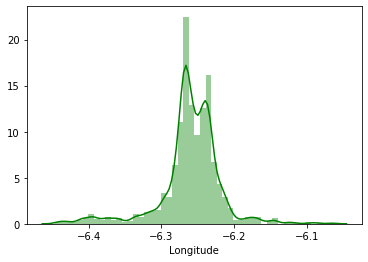

Histogram of latitude


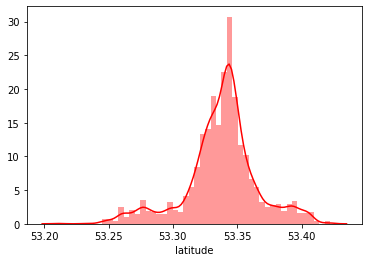

Histogram of dist_bridge


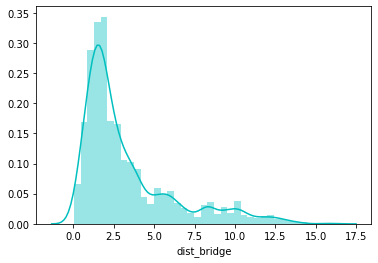

Histogram of dist_ifsc


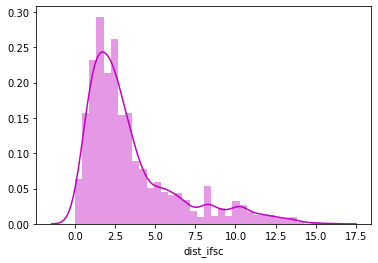

Histogram of dist_silicon_docks


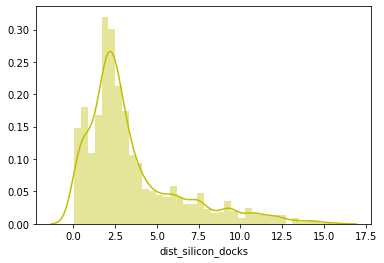

Histogram of price level


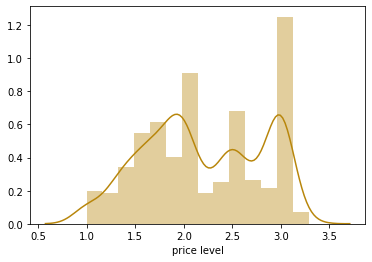

Histogram of rating


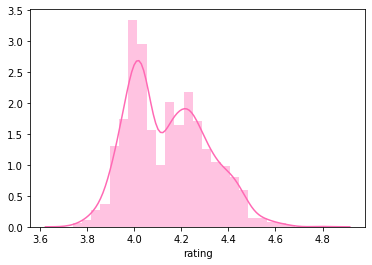

In [24]:
colours = ['b','g','r','c','m','y','darkgoldenrod', 'hotpink']
i=0
for column in rent_df:
    if np.issubdtype(rent_df[column].dtype, np.float64):
        print("Histogram of {}".format(str(column)))
        try:
            sns.distplot(rent_df[column],kde=True,color = colours[i])
            i += 1
            plt.show()
        except RuntimeError:
            pass
        

Boxplot of Monthly rent price(€)


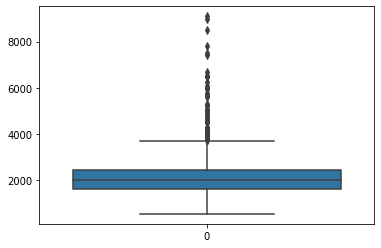

Boxplot's of dist_bridge, dist_ifsc and dist_silicon_docks


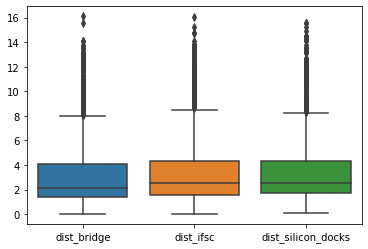

Boxplot's of price level and rating


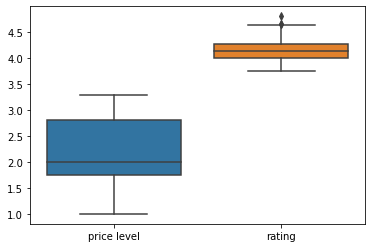

In [40]:
ds_dist = rent_df[['dist_bridge','dist_ifsc','dist_silicon_docks']]
print("Boxplot of Monthly rent price(€)")
sns.boxplot(data = rent_df["Monthly rent price(€)"])
plt.show()
print("Boxplot's of dist_bridge, dist_ifsc and dist_silicon_docks")
sns.boxplot(data=ds_dist)
plt.show()
print("Boxplot's of price level and rating")
sns.boxplot(data= rent_df[["price level","rating"]])
plt.show()


### Correlations of  Continuous Features 

There seems to be an issue of multicollinearity with dist_bridge, dist_ifsc and dist_silicon_docks. Multicollinearity exists whenever an independent variable is highly correlated with one or more of the other independent variables in a multiple regression equation. Multicollinearity is a problem because it undermines the statistical significance of an independent variable. 

There seems to be a moderate correlation between price level and dist_bridge indicating the prices of goods are higher in the city centre than in the outskirts  of the city.

The correlation between rating and dist_bridge   seems to indicate  nearby restaurants in the city centre have lower ratings compared to restaurants located further away from the city centre. However, this can be due to a larger amount of people attending such restaurants.

There is negative correlation between rating and price_level which makes sense as people expect more when paying for expensive food and when they don't receive good service they are more likely to leave a negative review.

Correlation does not equal causality so these are just my assumptions so far.



In [41]:
rent_df[["Monthly rent price(€)",'dist_bridge','dist_ifsc','dist_silicon_docks','price level','rating']].corr()

,Monthly rent price(€),dist_bridge,dist_ifsc,dist_silicon_docks,price level,rating
Monthly rent price(€),1.000000,0.013815,-0.020197,-0.074080,0.065253,0.127137
dist_bridge,0.013815,1.000000,0.978378,0.943882,-0.584483,0.614616
dist_ifsc,-0.020197,0.978378,1.000000,0.980608,-0.583078,0.588578
dist_silicon_docks,-0.074080,0.943882,0.980608,1.000000,-0.606065,0.488014
price level,0.065253,-0.584483,-0.583078,-0.606065,1.000000,-0.453573
rating,0.127137,0.614616,0.588578,0.488014,-0.453573,1.000000


### Correlations of Continuous Features and discrete features

I can't  use Pearson's correlation coefficent as it is only for continuous features.
I used Kendall's instead of Spearman's correlation because of a smaller gross error sensitivity (GES) (more robust) and a smaller asymptotic variance (AV) (more efficient).

The number of bedrooms and bathrooms seems to be moderately correlated with monthly rent price indicating, in general, the bigger the house the higher the price.

Correlation does not equal causality so these are just my assumptions so far.




In [43]:
rent_df[["Monthly rent price(€)",'Bedroom(s)','Bathroom(s)','Week YN', 'Month YN','Furnished Status','dist_bridge','dist_ifsc','dist_silicon_docks','price level','rating']].corr(method='kendall')

,Monthly rent price(€),Bedroom(s),Bathroom(s),Week YN,Month YN,Furnished Status,dist_bridge,dist_ifsc,dist_silicon_docks,price level,rating
Monthly rent price(€),1.000000,0.637368,0.552598,-0.065715,0.065715,-0.177288,0.007241,-0.048357,-0.103773,0.067074,0.079029
Bedroom(s),0.637368,1.000000,0.617868,-0.098551,0.098551,-0.217185,0.182836,0.144878,0.125227,-0.164131,0.163570
Bathroom(s),0.552598,0.617868,1.000000,-0.062101,0.062101,-0.230607,0.207589,0.142069,0.093972,-0.125580,0.195146
Week YN,-0.065715,-0.098551,-0.062101,1.000000,-1.000000,0.052013,-0.042223,-0.027800,-0.014235,0.009950,-0.021227
Month YN,0.065715,0.098551,0.062101,-1.000000,1.000000,-0.052013,0.042223,0.027800,0.014235,-0.009950,0.021227
Furnished Status,-0.177288,-0.217185,-0.230607,0.052013,-0.052013,1.000000,-0.125943,-0.115440,-0.090665,0.097920,-0.121423
dist_bridge,0.007241,0.182836,0.207589,-0.042223,0.042223,-0.125943,1.000000,0.756947,0.616558,-0.569105,0.559060
dist_ifsc,-0.048357,0.144878,0.142069,-0.027800,0.027800,-0.115440,0.756947,1.000000,0.799136,-0.570958,0.489563
dist_silicon_docks,-0.103773,0.125227,0.093972,-0.014235,0.014235,-0.090665,0.616558,0.799136,1.000000,-0.578163,0.324831
price level,0.067074,-0.164131,-0.125580,0.009950,-0.009950,0.097920,-0.569105,-0.570958,-0.578163,1.000000,-0.326431


In [44]:
both_corr = rent_df[["Monthly rent price(€)",'Bedroom(s)','Bathroom(s)','Week YN', 'Month YN','Furnished Status','dist_bridge','dist_ifsc','dist_silicon_docks','price level','rating']].corr(method='kendall')

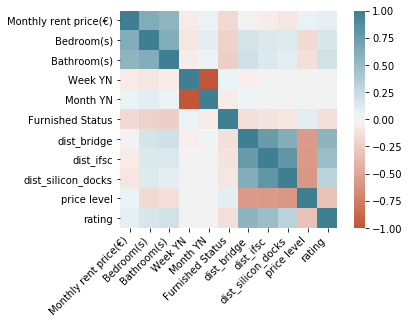

In [45]:
ax = sns.heatmap(
    both_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Barcharts of  discrete features:

#### Some inferences:

- The majority of rental properties in Dublin are furnished.

- The majority of  properties rental prices  are listed per month.

- Apartments are more common in the Dublin rental market than houses.

- The top 5 Dublin postal districts that have the highest amount of properties  are 4,2,8,1 and 6.

- The mode number of bathrooms and bedrooms are  1 and 2 respectively.



In [54]:

%%javascript
/* This diables the scroll window in a juypter notebook  */
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

barchat of Bedroom(s) total = 9


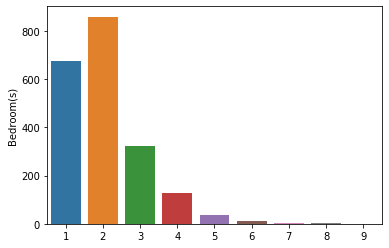

barchat of Bathroom(s) total = 8


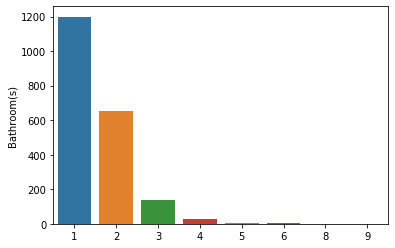

barchat of Furnished Status total = 2


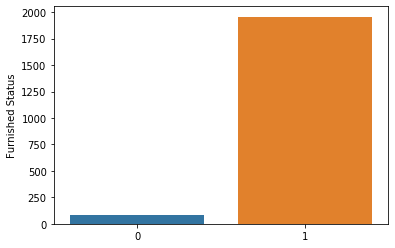

barchat of Week YN total = 2


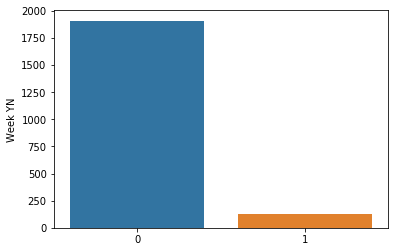

barchat of Month YN total = 2


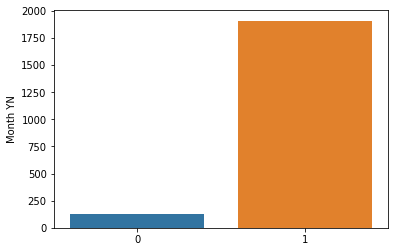

barchat of Type total = 2


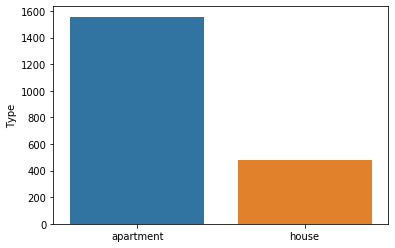

barchat of Post code total = 22


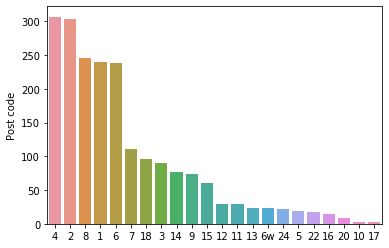

In [57]:
df_cat = rent_df[['Bedroom(s)','Bathroom(s)','Furnished Status','Week YN','Month YN', "Type", "Post code"]]
for i in df_cat.columns:
    cat_num =df_cat[i].value_counts()
    print("barchat of {} total = {}".format(i,len(cat_num)))
    sns.barplot(x=cat_num.index,y=cat_num,data=df_cat)
    plt.show()
    

Boxplot of Bedroom(s) and Bathroom(s)


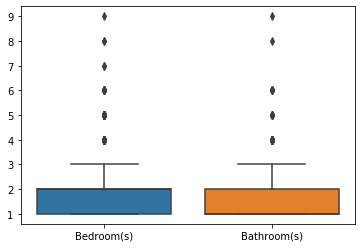

In [63]:
ds_house  = rent_df[['Bedroom(s)','Bathroom(s)']]
print("Boxplot of Bedroom(s) and Bathroom(s)")
sns.boxplot(data = ds_house)
plt.show()

# Digging deeper into the data



In [266]:
rent_df['price level'].fillna(value = price_level.median(),inplace=True)
rent_df.columns

Index(['Monthly rent price(€)', 'Type', 'Address', 'Post code', 'Bedroom(s)',
       'Bathroom(s)', 'Property desc', 'Week YN', 'Month YN',
       'Furnished Status', 'Longitude', 'latitude', 'dist_bridge', 'dist_ifsc',
       'dist_silicon_docks', 'coord', 'price level', 'rating'],
      dtype='object')

The sample mean of the apartment's rental prices is less than that of houses.
Although, down below a two-sample t=test indicates that their differences are not significant(5 % level of confidence).

The sample apartment dist_bridge mean is less than that of houses. This makes intuitive sense as land is scarce in the city centre. Therefore, land prices are more expensive in the city centre, leading to high rise developments, in order to gain the maximum value of the land available. Land is less scare in the outskirts. Houses are  more likely to be built here. Although down below a two-sample t=test indicates that their differences are not significant(5 % level of confidence).

As apartments are more likely to be  built in land pressure zones(ie the city centre where the average price of goods is higher than the outskirts), the sample apartment price_level mean is higher than that of houses. Although down below a two-sample t=test indicates that their differences are not significant(5 % level of confidence).

Rating of nearby restaurants grouped by type of property is not significant for my analysis.


In [271]:
pd.pivot_table(rent_df, index="Type" , values=["Monthly rent price(€)",'price level', 'rating', 'dist_bridge'], aggfunc=np.mean)

,Monthly rent price(€),dist_bridge,price level,rating
Type,,,,
apartment,1948.662619,2.895671,2.265007,4.124010
house,2701.247015,4.600227,1.914010,4.200716


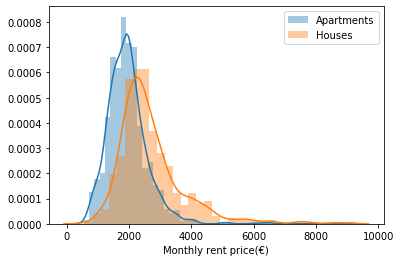

p value for dist_bridge: 1.4491864562948072e-30 and the tstatistic: -11.682346628213125
p value for price level: 3.6663096235752837e-31 and the tstatistic: 11.806418983691602
p value for rating: 8.070986881959923e-19 and the tstatistic: -8.946257343978061
p value for Monthly rent price(€): 2.8931033427562745e-70 and the tstatistic: -18.42944256128327


In [308]:
aprt = rent_df[rent_df.Type == "apartment" ]
home = rent_df[rent_df.Type == "house"]
sns.distplot(aprt["Monthly rent price(€)"],label="Apartments")
sns.distplot(home['Monthly rent price(€)'],label="Houses")
plt.legend()
plt.show()
columns=['dist_bridge','price level','rating','Monthly rent price(€)']
for col in columns:
    t_stat, p_val = stats.ttest_ind(aprt[col], home[col])
    print("p value for %s: " % (col) +str(p_val)+" and the tstatistic: " + str(t_stat))

A pivot table of Monthly rent price(€),	dist_bridge, price level and rating grouped by type and then by bedroom(s).
As expected, for both apartments and houses, generally, rent prices increased as the number of bedrooms increased.
The other features are more ambiguous as there is no clear trend.


In [272]:
pd.pivot_table(rent_df, index=["Type",'Bedroom(s)'] , values=["Monthly rent price(€)",'price level', 'rating', 'dist_bridge'], aggfunc=np.mean)

Monthly rent price(€)  dist_bridge  price level  \
Type      Bedroom(s)                                                    
apartment 0                     1450.000000     3.413596     1.500000   
          1                     1483.785634     2.612690     2.247237   
          2                     2166.375642     3.043770     2.319812   
          3                     2744.725621     3.236697     2.133849   
          4                     2514.500000     3.579767     1.709091   
          5                     4230.556667     7.994215     1.250000   
          6                     2049.667500     1.699450     2.214286   
house     1                     1522.517368     2.840277     2.116572   
          2                     2168.294234     3.082328     2.219871   
          3                     2528.672619     5.412985     1.797065   
          4                     3185.444444     5.191335     1.760950   
          5                     3933.441176     6.029288     1.711169   
          6                     5465.555000     2.385336     2.587393   
          7                     6775.000000     2.519597     1.666667   
          8                     5133.335000     3.458595     1.833333   
          9                     7500.000000     5.407702     1.333333   

                        rating  
Type      Bedroom(s)            
apartment 0           4.351163  
          1           4.111252  
          2           4.126435  
          3           4.158135  
          4           4.189242  
          5           4.375296  
          6           3.994886  
house     1           4.101254  
          2           4.127080  
          3           4.225761  
          4           4.248800  
          5           4.266693  
          6           4.133240  
          7           4.222488  
          8           4.236953  
          9           4.365854

When it comes to the total number of bedrooms and bathrooms vs rental price of a property, there is a very clear upwards sloping trend relationship between the two! However, that is also not the only factor as there are large  properties going for as little as €1000 a month and as high as €9100.

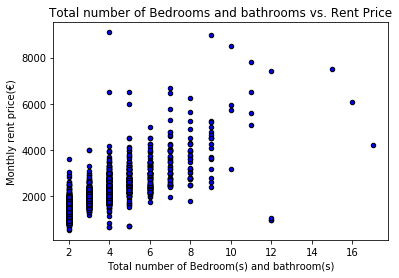

In [89]:
plt.figure()
plt.scatter(rent_df['Bedroom(s)'] + rent_df['Bathroom(s)'] ,rent_df['Monthly rent price(€)'], s=20,
edgecolor="black",c="blue")
plt.xlabel("Total number of Bedroom(s) and bathroom(s)")
plt.ylabel('Monthly rent price(€)')
plt.title("Total number of Bedrooms and bathrooms vs. Rent Price")
plt.show()

A pivot table of Monthly rent price(€),	dist_bridge, price level and rating grouped by postcode.
The top 5 most expensive neighbourhoods are 4,14,2,16 and 18.


In [277]:
pd.pivot_table(rent_df, index=["Post code"] , values=["Monthly rent price(€)",'price level', 'rating', 'dist_bridge'], aggfunc=np.mean).sort_values(by="Monthly rent price(€)", ascending=False)


,Monthly rent price(€),dist_bridge,price level,rating
Post code,,,,
4,2484.891433,2.597521,2.446882,4.232912
14,2442.238052,5.974664,1.647851,4.254518
2,2406.182007,1.072027,2.900507,4.032433
16,2337.800000,7.987341,1.567778,4.341722
18,2276.819375,9.857937,2.021197,4.357796
6w,2205.782609,4.470570,1.609321,4.309084
12,2170.977241,4.806211,1.326437,4.320489
13,2133.958333,10.317283,1.719593,4.341406
6,2084.465774,3.063919,1.974392,4.279724


Furnished properties are generally smaller than furnished ones. Therefore, rental prices for furnished properties are lower. Also, unfurnished properties tend to be located further away from the city centre. However, the sample sizes differ widely so we have to take our conclusions with a pinch of salt.

In [281]:
pd.pivot_table(rent_df, index=["Furnished Status",] , values=["Monthly rent price(€)", 'dist_bridge','Bathroom(s)','Bedroom(s)'], aggfunc=np.mean).sort_values(by="Monthly rent price(€)", ascending=False)


,Bathroom(s),Bedroom(s),Monthly rent price(€),dist_bridge
Furnished Status,,,,
0,2.607595,3.405063,3265.873418,5.308143
1,1.496425,1.982125,2079.627007,3.215332


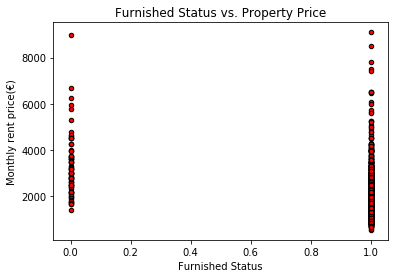

In [66]:
plt.figure()
plt.scatter(rent_df['Furnished Status'],rent_df['Monthly rent price(€)'], s=20,
edgecolor="black",c="red", label="furnished status")
plt.xlabel('Furnished Status')
plt.ylabel("Monthly rent price(€)")
plt.title("Furnished Status vs. Property Price")
plt.show()

The number of furnished properties far outnumber unfurnished ones. 3.9 % of properties in the Dublin rental market are unfurnished.

In [290]:
pd.pivot_table(rent_df, index=["Furnished Status",] , values=["Type"], aggfunc= 'count')

,Type
Furnished Status,
0,79
1,1958


In [299]:
pd.pivot_table(rent_df, index= "Post code" ,columns = "Type", values="Monthly rent price(€)")

Type,apartment,house
Post code,,
1,1976.955845,2505.380952
10,1833.333333,NaN
11,1157.767000,2275.000000
12,1798.030909,2398.888889
13,1950.333333,2317.583333
14,2211.070851,2804.400000
15,1830.892857,2244.406250
16,1873.857143,2743.750000
17,1112.500000,1750.000000


I wanted to know if they were are any major differences between properties where their rental prices were listed weekly or monthly. The average sample mean for properties listed per month is higher than if they were listed weekly, which was surprising as I thought it would be the opposite!

Although down below a two-sample t=test  indicates that their differences are not significant(5 % level of confidence).

The mean price level, rating and dist_bridge for weekly and monthly are also not significantly  different.

In [301]:
week = rent_df[rent_df['Week YN'] == 1]
month =  rent_df[rent_df['Month YN'] == 1]

week.reset_index(drop=True, inplace = True)
month.reset_index(drop=True, inplace = True)

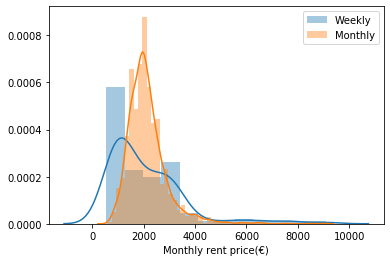

p value for dist_bridge: 0.012137162553611084 and the tstatistic: -2.510379455147933
p value for price level: 0.6346647154070946 and the tstatistic: 0.47524309668792597
p value for rating: 0.12558873593199182 and the tstatistic: -1.5323613062829835
p value for Monthly rent price(€): 0.41437917934339197 and the tstatistic: -0.8163786076329914


In [311]:
sns.distplot(week["Monthly rent price(€)"],label="Weekly")
sns.distplot(month['Monthly rent price(€)'],label="Monthly")
plt.legend()
plt.show()
columns=['dist_bridge','price level','rating','Monthly rent price(€)']
for col in columns:
    t_stat, p_val = stats.ttest_ind(week[col], month[col])
    print("p value for %s: " % (col) +str(p_val)+" and the tstatistic: " + str(t_stat))

# Identifying And Visualising Rental Market Trends In Dublin:

As I have the longitude and latitude of each property, we can visualize how  rental prices are distributed geographically. This may enable us to spot any trends that might be relevant for my analysis. I will do this with a Google Map API called gmaps.

As expected, most of the higher rent prices are concentrated around the city center, specifically around 0'Connell's bridge and  the Docklands. Higher rent prices are  also concentrated around Ballsbridge and Rathmines, where there is a concentration of luxury houses. The further out neighbourhoods of northside Dublin such as  Ballymun, Artane and  Finglas appear to have lower rental prices represented in green.

Location seems to have a strong effect on rental prices, but it is definitely not the sole factor.



In [ ]:
api_key = os.environ["APIKEY"]
gmaps.configure(api_key)

fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(
  rent_df[['latitude','Longitude']],
  weights=rent_df['Monthly rent price(€)'],
  max_intensity = 1000,
  point_radius=6.0
)

fig.add_layer(heatmap_layer)
fig

### Rental Price Heatmap Of Dublin
<img src="../data/dublin_heat_map.png" alt="drawing" width="600"/>


# Wordcloud of Rental Property descriptions

A 'word cloud' is a visual representation of word frequency. The more commonly the term appears, within the text being analysed, the larger the word appears in the image generated. It comes as no surprise that positive descriptors such as bright, private,sought after, beautiful, modern and spacious are commonplace. "Available now" appeared in most descriptions indicating that the property was available to view immediately. In addition, Dublin and June are common as, of course, this is an analysis of Dublin rental prices viewed in June 2020.

In [ ]:
text = ""
for index,values in  rent_df['Property desc'].items():
    text += values.strip()
text = text.replace("\n","")
mask = np.array(Image.open('..\data\wc.png'))
stopwords = set(STOPWORDS)
wc = WordCloud(background_color="White",stopwords=stopwords).generate(text)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

<img src="..\data\WordCloud.png" alt="drawing" width="400"/>

In [74]:
rent_df.to_hdf("../data/after_eda.h5", key='df', mode='w')